# Analisis de la movilidad urbana utilizando estadisticas del Comoir

En este notebook intento realizar un analisis geoespacial de la movilidad urbana utilizando como fuente de datos las estadisticas de uso de la aplicacion Comoir publicadas por la IMM.

Primero lo primero - Los import!

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pysal as ps
import geopandas as gpd
from sklearn import cluster
from sklearn.preprocessing import scale
import shapely

%matplotlib inline

separador = ';'

Algunas referencias a los archivos shapefile y csv para luego poder cargar los que realmetne necesito. Al momento de empezar con el notebook no tengo ni idea de cuales me van a servir y cuales no. Bueno, en realidad se que los csv con las estadisticas de las consultas realizadas por los usuarios los preciso, sino para que estoy haciendo esto?

In [15]:
barrios_shp_path = 'barrios/barrios.shp' #shapefile con los barrios de montevideo
vias_shp_path = 'v_mdg_vias/v_mdg_vias.shp' #shapefile con las vias (calles, caminos, pasajes, etc.) de mvdeo
destino_shp_path = 'v_uptu_lsv_destinos/v_uptu_lsv_destinos.shp' #shapefile con los destino... ni se porque lo baje

manzanas_shp_path = 'v_mdg_manzanas/v_mdg_manzanas.shp' #shapefile con las manzanas
accesos_shp_path = 'v_mdg_accesos/v_mdg_accesos.shp' #shapefile con las calles y su numeracion. 
cultura_csv_path = 'v_uptu_lugares/uptu_cultura.csv.gz' #shapefile con la ubicacion de los centros culturales
deporte_csv_path = 'v_uptu_lugares/uptu_deporte.csv.gz' #shapefile con los lugares centros deportivos
educacion_csv_path = 'v_uptu_lugares/uptu_educacion.csv.gz' #shapefile con los centros educativos 
patrimonio_csv_path = 'v_uptu_lugares/uptu_patrimonio.csv.gz' #shapefile con los lugares patrimoniales
playa_csv_path = 'v_uptu_lugares/uptu_playa.csv.gz' #shapefile con las playas
salud_csv_path = 'v_uptu_lugares/uptu_salud.csv.gz' #shapefile con los centros de salud
espacios_shp_path = 'v_mdg_espacios_libres/v_mdg_espacios_libres.shp' #shapefile de espacios libres (parques, plazas, etc)
monumentos_shp_path = 'v_mdg_ubicaciones_notables/v_mdg_ubicaciones_notables.shp' #shapefile de monumentos

Los datos con las estadisticas estan separados en 1 archivo por año. Del 2010 al 2013 inclusive, contienen la información todo el año, mientras que el 2014 solo incluye información del primer semestre de ese año. Las busquedas que se pueden hacer en Comoir son de 3 tipos por cada punto del recorrido (origen y destino) lo que da un total de 6 tipos diferentes combinados. Las busquedas pueden hacerse por:
    - Esquina: curce de calles
    - Dirección: calle y número
    - Lugar de interés

Cada csv indica el tipo de origen, el tipo de destino, y para cada uno de ellos se indica 1 o 2 códigos. Si el tipo es dirección o lugar de interes el código identifica la calle o el lugar de interes respectivamente. Si el tipo es esquina se indica un segundo código, donde el primero identifica una calle y el segundo la otra. Los códigos hacen referencia a los otros shapefile, para las calles se hace referencia a vias_shp_path, y para lugares de interes se hace referencia a cultura_shp_path, deporte_shp_path, educacion_shp_path, patrimonio_shp_path, playa_shp_path, salud_shp_path, espacios_shp_path y monumentos_shp_path.

In [7]:
r2010_csv_path = 'comoir/comoir_2010_1.csv.gz'
r2011_csv_path = 'comoir/comoir_2011_1.csv.gz'
r2012_csv_path = 'comoir/comoir_2012_1.csv.gz' 
r2013_csv_path = 'comoir/comoir_2013_1.csv.gz'
r2014_csv_path = 'comoir/comoir_2014_1.csv.gz'

In [ ]:
vias_data = ps.open(vias_shp_path)

In [ ]:
vias_data.header

In [ ]:
all_polygons = vias_data.read()

In [ ]:
len(all_polygons)

In [ ]:
vias_data_table = ps.pdio.read_files(vias_shp_path)

In [ ]:
vias_data_table.head()

In [ ]:
v7815 = vias_data_table.query('COD_NOMBRE==7815')
v7815

In [ ]:
v7815.geometry[4475]

In [ ]:
destinos_table = ps.pdio.read_files(destino_shp_path)

In [ ]:
destinos_table.head()

In [ ]:
destinos_table.query('GID==277347')

In [ ]:
vias_data_table.query('GID==16009406')

In [64]:
r2010_table = pd.read_csv(r2010_csv_path)

In [ ]:
r2010_table.query('codigo_origen_1==4401')

In [ ]:
dstgpd = gpd.read_file(destino_shp_path)

In [4]:
vgpd = gpd.read_file(vias_shp_path)

In [ ]:
bgpd = gpd.read_file(barrios_shp_path)

In [5]:
vgpd.head()

,CAB_DESDE_,CAB_DES_01,CAB_HASTA_,CAB_HAS_01,COD_DEPTO,COD_LOCALI,COD_NOMBRE,GID,NOM_CALLE,SENTIDO_NU,geometry
0,0.0,0.0,0.0,0.0,1,20,6774,277347.0,TAMANDUA,None,"LINESTRING (559598.006110086 6149999.06691935,..."
1,0.0,0.0,0.0,0.0,1,20,2466,277348.0,ECUADOR,None,"LINESTRING (568230.301927603 6139309.94672106,..."
2,0.0,0.0,0.0,0.0,1,20,6004,277349.0,RIO DE JANEIRO,None,"LINESTRING (568230.301927603 6139309.94672106,..."
3,0.0,0.0,0.0,0.0,1,20,3256,277352.0,GUINEA,None,"LINESTRING (566802.788552275 6139319.91464599,..."
4,0.0,0.0,0.0,0.0,1,20,5514,277353.0,PIRARAJA,None,"LINESTRING (559589.957884449 6150013.65479495,..."


In [ ]:
f, ax = plt.subplots(1, figsize=(5, 5))
V2752 = vgpd.query('COD_NOMBRE==4401')
V2752.plot(color='#BEEDAA', ax=ax)

ax.set_axis_off()

plt.show()

In [7]:
ejes = gpd.read_file('ejesinv/ejesinv.shp')

In [4]:
r2010 = pd.read_csv(r2010_csv_path)

In [ ]:
sns.jointplot(color='blue',)

In [18]:
ejes.columns

Index(['CARANCAL', 'CARANCMED', 'CARCANT', 'CARCAPROD', 'CARCAPROI',
       'CARDOBVIA', 'CARESALC', 'CARESCUD', 'CARESCUI', 'CARESPEST', 'CAREST',
       'CARESTGRL', 'CAREXIVIA', 'CARFECREL', 'CARIES', 'CARLARMED',
       'CARNROALC', 'CARNROLOS', 'CARPRIO', 'CARSEPE', 'CARVIA1COD',
       'CARVIA2COD', 'CARVISCOD', 'CARVISCOI', 'CCZLIM_ID', 'CENCOMCOD',
       'CODBA', 'CODIGO', 'EJES_', 'EJES_ID', 'FIRCOD', 'IMM96_', 'IMM96_ID',
       'LENGTH', 'NOMBRE', 'PAV_ID', 'RELCOD', 'TIPO', 'TITULO', 'VIA',
       'VIACOD', 'VIADSC', 'VIAL_ID', 'geometry'],
      dtype='object')

In [ ]:
manzanas = gpd.read_file(manzanas_shp_path)

In [ ]:
f, ax = plt.subplots(1, figsize=(10, 10))
manzanas.plot(color='#BEEDAA', ax=ax)

ax.set_axis_off()

plt.show()

In [63]:
eje_rivera = ejes.query('CODIGO==6051 | CODIGO==339')
eje_sanca = ejes.query('CODIGO==339')

ejeg = eje_rivera.groupby('NOMBRE')['geometry'].agg(lambda x: shapely.ops.linemerge(x.values))
inter = ejeg[0].intersection(ejeg[1])
print(inter.x)
print(inter.y)

580952.0631582628
6138536.370836188


In [6]:
vgpd.query('COD_NOMBRE==339')

,CAB_DESDE_,CAB_DES_01,CAB_HASTA_,CAB_HAS_01,COD_DEPTO,COD_LOCALI,COD_NOMBRE,GID,NOM_CALLE,SENTIDO_NU,geometry
2384,0.0,0.0,0.0,0.0,1,20,339,287742.0,SANTIAGO DE ANCA,None,"LINESTRING (581019.144881355 6138967.48137208,..."
2596,0.0,0.0,0.0,0.0,1,20,339,288148.0,SANTIAGO DE ANCA,None,"LINESTRING (580994.1789098 6138793.81592637, 5..."
2962,0.0,0.0,0.0,0.0,1,20,339,288817.0,SANTIAGO DE ANCA,None,"LINESTRING (581130.189216885 6138329.37062164,..."
10044,NaN,NaN,NaN,NaN,1,20,339,4376705.0,SANTIAGO DE ANCA,None,"LINESTRING (581165.898412601 6138331.30471895,..."
13788,0.0,0.0,0.0,0.0,1,20,339,6073783.0,SANTIAGO DE ANCA,None,LINESTRING (581322.3780450911 6138161.24469714...
25673,NaN,NaN,NaN,NaN,1,20,339,7383373.0,SANTIAGO DE ANCA,None,"LINESTRING (581005.584639078 6138445.50042717,..."
29462,NaN,NaN,NaN,NaN,1,20,339,15304504.0,SANTIAGO DE ANCA,None,"LINESTRING (580907.613502934 6138626.35967085,..."
29463,NaN,NaN,NaN,NaN,1,20,339,15304507.0,SANTIAGO DE ANCA,None,LINESTRING (580958.5224454639 6138531.93504789...
29466,NaN,NaN,NaN,NaN,1,20,339,15304510.0,SANTIAGO DE ANCA,None,LINESTRING (580954.2488846889 6138540.40496527...


In [ ]:
rivera = vgpd.query('COD_NOMBRE==6051')
sanca = vgpd.query('COD_NOMBRE==339')

In [ ]:
sx = rivera.intersects(sanca)

In [ ]:
inter = gpd.GeoDataFrame(geometry=sx)

In [ ]:
vgpd.query('NOM_CALLE=="AV ITALIA"')

Levanto los tipos de ubicaciones para agregar a cada uno la columna tipo. El valor de esta columna sirve para luego hacer el merge con los origenes y destinos de cada estadistica para poder asociar a los mismos las coordenadas.

In [16]:
cu = pd.read_csv(cultura_csv_path)      #cultura         - tipo 3
de = pd.read_csv(deporte_csv_path)      #deporte         - tipo 4
ed = pd.read_csv(educacion_csv_path)    #educacion       - tipo 5
pa = pd.read_csv(patrimonio_csv_path)   #patrimonio      - tipo 9
pl = pd.read_csv(playa_csv_path)        #playa           - tipo 10
sa = pd.read_csv(salud_csv_path)        #salud           - tipo 11
el = gpd.read_file(espacios_shp_path)   #espacios libres - tipo 6 espacio libre
pq = el[np.isfinite(el['COD_NOM_PA'])]  #parques         - tipo 7
el = el[np.isfinite(el['COD_NOM_ES'])]  #espacio libre   - tipo 6
mo = gpd.read_file(monumentos_shp_path) #monumentos      - tipo 8

FileNotFoundError: [Errno 2] No such file or directory: 'v_uptu_lugares/uptu_cultura.csv.gz'

In [9]:
cu.loc[:,'tipo'] = 3
de.loc[:,'tipo'] = 4
ed.loc[:,'tipo'] = 5
pa.loc[:,'tipo'] = 9
pl.loc[:,'tipo'] = 10
sa.loc[:,'tipo'] = 11
el.loc[:,'tipo'] = 6
el.loc[:,'codigo'] = el['COD_NOM_ES'].apply(lambda c: c)
el.loc[:,'x'] = el['geometry'].apply(lambda p: p.centroid.x)
el.loc[:,'y'] = el['geometry'].apply(lambda p: p.centroid.y)
pq.loc[:,'tipo'] = 7
pq.loc[:,'codigo'] = pq['COD_NOM_PA'].apply(lambda c: c)
pq.loc[:,'x'] = pq['geometry'].apply(lambda p: p.centroid.x)
pq.loc[:,'y'] = pq['geometry'].apply(lambda p: p.centroid.y)
mo.loc[:,'x'] = mo['geometry'].apply(lambda p: p.x)
mo.loc[:,'y'] = mo['geometry'].apply(lambda p: p.y)
mo = mo.dropna(subset=['COD_NOM_UB'])
mo.loc[:,'tipo'] = 8
mo.loc[:,'codigo'] = mo['COD_NOM_UB'].apply(lambda c: c)

In [10]:
r2010 = pd.read_csv(r2010_csv_path)

In [11]:
tipos = cu.append(de.append(ed.append(pa.append(pl.append(sa.append(pq.append(el.append(mo,ignore_index=True),
                                                                              ignore_index=True),
                                                                    ignore_index=True),
                                                          ignore_index=True),
                                                ignore_index=True),
                                      ignore_index=True), 
                            ignore_index=True), 
                  ignore_index=True)
tipos = tipos[['codigo', 'tipo', 'x', 'y']]

In [15]:
r2010.merge(tipos,left_on=['codigo_origen_1', 'codigo_origen_2', 'tipo_origen'], right_on=['codigo', 'codigo', 'tipo'], how='inner')

,id,sesion,fecha,tipo_viaje,tipo_origen,codigo_origen_1,codigo_origen_2,desc_origen,tipo_destino,codigo_destino_1,...,es_combinacion,radio_max,largo_resp,tiempo,es_dd_origen,es_dd_destino,codigo,tipo,x,y


In [20]:
#r2010.query('tipo_origen != 1 & tipo_origen != 2').groupby(['tipo_origen'])['id'].count().sum()
#Obtengo el x, y de cada origen_1. Faltan el x, y de cada origen_2 y luego el destino_1 y destino_2
rmerge = r2010.merge(tipos, left_on=['codigo_origen_1', 'tipo_origen'], 
                     right_on=['codigo', 'tipo'], 
                     how='inner')\
            .merge(tipos, left_on=['codigo_destino_1', 'tipo_destino'], right_on=['codigo', 'tipo'], how='inner')

In [21]:
rmerge = rmerge.drop_duplicates(subset='id', keep='first') #lugar de interes a lugar de interes

id                  1675
sesion              1675
fecha               1675
tipo_viaje          1675
tipo_origen         1675
codigo_origen_1     1675
codigo_origen_2        0
desc_origen         1675
tipo_destino        1675
codigo_destino_1    1675
codigo_destino_2       0
desc_destino        1675
distancia           1675
es_combinacion      1324
radio_max           1324
largo_resp          1324
tiempo              1675
es_dd_origen           0
es_dd_destino          0
codigo_x            1675
tipo_x              1675
x_x                 1675
y_x                 1675
codigo_y            1675
tipo_y              1675
x_y                 1675
y_y                 1675
dtype: int64

In [ ]:
x

In [ ]:
pa

In [ ]:
pa.query('codigo==181')

In [ ]:
pa.sort_values(by='codigo')

In [15]:
f = ps.pdio.read_files(monumentos_shp_path)

In [18]:
point = f.geometry[0]

In [24]:
lst = [point, point]

In [30]:
[x for (x,_) in lst]

[(573459.8698154868, 6141475.190073518),
 (573459.8698154868, 6141475.190073518)]

In [32]:
[x for (x,_) in lst]+[y for (_,y) in lst]

[573459.8698154868, 573459.8698154868, 6141475.190073518, 6141475.190073518]

In [87]:
r2010.query('tipo_origen==2')

id                  92552
sesion              92552
fecha               92552
tipo_viaje          92552
tipo_origen         92552
codigo_origen_1     92552
codigo_origen_2     92552
desc_origen         92552
tipo_destino        92552
codigo_destino_1    92552
codigo_destino_2    88072
desc_destino        92552
distancia           92552
es_combinacion      72736
radio_max           72736
largo_resp          72736
tiempo              92552
es_dd_origen            0
es_dd_destino           0
dtype: int64

In [30]:
tipos.geometry

0                                               NaN
1                                               NaN
2                                               NaN
3                                               NaN
4                                               NaN
5                                               NaN
6                                               NaN
7                                               NaN
8                                               NaN
9                                               NaN
10                                              NaN
11                                              NaN
12                                              NaN
13                                              NaN
14                                              NaN
15                                              NaN
16                                              NaN
17                                              NaN
18                                              NaN
19          

In [24]:
cgdp = gpd.read_file(accesos_shp_path)

In [9]:
r2010.head()

,id,sesion,fecha,tipo_viaje,tipo_origen,codigo_origen_1,codigo_origen_2,desc_origen,tipo_destino,codigo_destino_1,codigo_destino_2,desc_destino,distancia,es_combinacion,radio_max,largo_resp,tiempo,es_dd_origen,es_dd_destino
0,559,72D0C0D7F0DCECB78F944793776AA30B,2010-04-16 16:19:41,O,2,7815,0.0,G DE GOUVEIA DE MICHELENA 1485,3,881,NaN,TEATRO DE VERANO,4136.54,F,1246.750,10.0,10417,NaN,NaN
1,2993,8C07FE7E33326592EADD8A836B74C8C3,2010-04-21 20:04:48,C,2,5319,0.0,LA PAZ 1788,2,7815,0.0,G DE GOUVEIA DE MICHELENA 1485,4597.31,NaN,NaN,NaN,6421,NaN,NaN
2,777,02A7BE81E19ED8047566837D5A156629,2010-04-16 23:30:05,O,6,2953,NaN,PLAZA DE CAGANCHA,6,2841,NaN,PLAZUELA REPUBLICA DE CUBA,3886.35,F,421.591,16.0,11321,NaN,NaN
3,14620,32F787CA3AE5FAF2ED5541F9A27ECCA1,2010-05-14 17:09:16,O,8,6020,NaN,VELODROMO ATILIO GARCIA,1,2949,4536.0,AV GRAL JOSE GARIBALDI y MONTE CASEROS,1506.14,F,1029.500,12.0,21599,NaN,NaN
4,23317,6CD237DF3B48578850B7900769B0406B,2010-06-03 18:04:47,O,8,5820,NaN,MONOLITO APORTES BRITANICOS AL URUGUAY,8,5361,NaN,ESTELA BADEN POWELL,10213.30,F,1500.000,0.0,72167,NaN,NaN


In [25]:
cgdp.loc[:,'direccion'] = cgdp['NOM_CALLE'] + ' ' + cgdp['NUM_PUERTA'].map(str)
cgdp.loc[:,'x'] = cgdp['geometry'].apply(lambda p: p.x)
cgdp.loc[:,'y'] = cgdp['geometry'].apply(lambda p: p.y)
cgdp.loc[:,'tipo'] = 2
dirs = cgdp[['COD_NOMBRE', 'tipo', 'direccion','x','y']]
dirs.head()

,COD_NOMBRE,tipo,direccion,x,y
0,1815,2,SEPEE 1785,582942.526278,6.139383e+06
1,2049,2,AV COLOMBES 1620,580697.020043,6.138677e+06
2,2049,2,AV COLOMBES 1618,580701.579438,6.138669e+06
3,7248,2,EUSEBIO VIDAL 2915,580952.087982,6.142637e+06
4,2049,2,AV COLOMBES 1616,580706.148171,6.138660e+06


In [26]:
#rivera = cgdp.query('COD_NOMBRE==6051')
cons_t2 = r2010.merge(dirs, left_on=['codigo_origen_1', 'tipo_origen'], right_on=['COD_NOMBRE', 'tipo'], how='inner')

In [27]:
#qr = r2010.query('codigo_origen_1==6051 & tipo_origen==2')
#direcciones.query('COD_NOMBRE==7815')
cons_t2 = cons_t2.query('desc_origen==direccion') #las consultas con tipo_origen = 2
#cons_t2['id'].count()


In [28]:
cons_t2 = cons_t2.drop_duplicates(subset='id',keep='first')

In [32]:
rmerge.head()

,id,sesion,fecha,tipo_viaje,tipo_origen,codigo_origen_1,codigo_origen_2,desc_origen,tipo_destino,codigo_destino_1,...,es_dd_origen,es_dd_destino,codigo_x,tipo_x,x_x,y_x,codigo_y,tipo_y,x_y,y_y
0,777,02A7BE81E19ED8047566837D5A156629,2010-04-16 23:30:05,O,6,2953,NaN,PLAZA DE CAGANCHA,6,2841,...,NaN,NaN,2953.0,6,573869.409357,6.137120e+06,2841.0,6,572857.950013,6.140842e+06
3,109172,7BFF06E8AE171A3819ABEBE512327C8E,2010-10-07 11:42:15,O,11,269,NaN,HOSPITAL DR GUSTAVO SAINT BOIS,6,2841,...,NaN,NaN,269.0,11,569369.200000,6.150154e+06,2841.0,6,572857.950013,6.140842e+06
4,210627,9D7614BE2E26367A3FA7257ED33E8E74,2010-12-16 00:54:35,O,6,2904,NaN,PLAZA INDEPENDENCIA,6,2841,...,NaN,NaN,2904.0,6,573106.304106,6.137031e+06,2841.0,6,572857.950013,6.140842e+06
5,111020,720217678815B0E85579CF8B1731D80D,2010-10-08 20:23:43,O,3,878,NaN,CINE MOVIECENTER PORTONES SHOPPING,6,2841,...,NaN,NaN,878.0,3,583820.799719,6.139610e+06,2841.0,6,572857.950013,6.140842e+06
6,111023,051599EAAABE6A5454D9691CE64F2CC6,2010-10-08 20:28:13,O,3,878,NaN,CINE MOVIECENTER PORTONES SHOPPING,6,2841,...,NaN,NaN,878.0,3,583820.799719,6.139610e+06,2841.0,6,572857.950013,6.140842e+06


In [104]:
def address_point(stats, addressess):
    points = []
    for a in ststs.iterrows():
        for n in addressess.iterrows():
            if n[1].direccion == a[1].desc_origen:
                points.insert(0, [a[1].desc_origen, n[1].geometry.x, n[1].geometry.y])
    return gpd.GeoDataFrame(columns=['nombre', 'x', 'y'], data=points)

In [105]:
%time puntos = address_point(qr, rivera)

CPU times: user 4min 39s, sys: 3.24 s, total: 4min 42s
Wall time: 4min 47s


In [108]:
puntos = puntos.drop_duplicates()

In [89]:
rivera.query('NUM_PUERTA==3393')

,COD_NOMBRE,GID,LETRA,NOM_CALLE,NUM_PUERTA,PADRON,PARIDAD,geometry,blanco,direccion
270114,6051,320699.0,None,AV GRAL RIVERA,3393,28458,None,POINT (578456.0538481351 6137499.11920194),,AV GRAL RIVERA 3393


In [90]:
qr.query('id==225122')

,id,sesion,fecha,tipo_viaje,tipo_origen,codigo_origen_1,codigo_origen_2,desc_origen,tipo_destino,codigo_destino_1,codigo_destino_2,desc_destino,distancia,es_combinacion,radio_max,largo_resp,tiempo,es_dd_origen,es_dd_destino
195243,225122,BBCC4AEE77832C941C3A79E7BB5A1A47,2010-12-22 22:24:55,O,2,6051,0.0,AV GRAL RIVERA 3393,4,224,NaN,ESTADIO CENTENARIO,1469.62,F,347.021,6.0,4407,NaN,NaN


In [76]:
rivera.loc[:,'blanco'] = ' '

/Users/danielbonini/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/danielbonini/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [79]:
rivera.loc[:,'direccion'] = rivera['NOM_CALLE'] + rivera['blanco'] + rivera['NUM_PUERTA'].map(str)

/Users/danielbonini/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/danielbonini/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [80]:
rivera

,COD_NOMBRE,GID,LETRA,NOM_CALLE,NUM_PUERTA,PADRON,PARIDAD,geometry,blanco,direccion
3862,6051,10851.0,None,AV GRAL RIVERA,4197,62407,None,POINT (580148.283702778 6138096.9187394),,AV GRAL RIVERA 4197
7198,6051,14771.0,None,AV GRAL RIVERA,3820,127324,None,POINT (579451.327246474 6137715.18378588),,AV GRAL RIVERA 3820
7199,6051,14774.0,None,AV GRAL RIVERA,3822,127324,None,POINT (579451.327246474 6137715.18378588),,AV GRAL RIVERA 3822
7209,6051,14788.0,None,AV GRAL RIVERA,3812,127322,None,POINT (579431.570888134 6137717.82389758),,AV GRAL RIVERA 3812
7210,6051,14789.0,None,AV GRAL RIVERA,3814,127322,None,POINT (579431.570888134 6137717.82389758),,AV GRAL RIVERA 3814
7214,6051,14794.0,None,AV GRAL RIVERA,3824,127324,None,POINT (579451.327246474 6137715.18378588),,AV GRAL RIVERA 3824
7219,6051,14800.0,None,AV GRAL RIVERA,3816,127323,None,POINT (579441.465038358 6137716.50170798),,AV GRAL RIVERA 3816
7221,6051,14802.0,None,AV GRAL RIVERA,3818,127323,None,POINT (579441.465038358 6137716.50170798),,AV GRAL RIVERA 3818
7250,6051,14842.0,None,AV GRAL RIVERA,3710,127338,None,POINT (579219.254039928 6137747.4750175),,AV GRAL RIVERA 3710
7275,6051,14883.0,None,AV GRAL RIVERA,3712,127338,None,POINT (579219.254039928 6137747.4750175),,AV GRAL RIVERA 3712


In [114]:
puntos.query('nombre=="AV GRAL RIVERA 4197"')

,nombre,x,y


In [113]:
rivera.query('direccion=="AV GRAL RIVERA 4197"')

,COD_NOMBRE,GID,LETRA,NOM_CALLE,NUM_PUERTA,PADRON,PARIDAD,geometry,blanco,direccion
3862,6051,10851.0,None,AV GRAL RIVERA,4197,62407,None,POINT (580148.283702778 6138096.9187394),,AV GRAL RIVERA 4197


In [116]:
qr.query('desc_origen=="AV GRAL RIVERA 4197"')

,id,sesion,fecha,tipo_viaje,tipo_origen,codigo_origen_1,codigo_origen_2,desc_origen,tipo_destino,codigo_destino_1,codigo_destino_2,desc_destino,distancia,es_combinacion,radio_max,largo_resp,tiempo,es_dd_origen,es_dd_destino


In [7]:
r2010.query('tipo_origen==1')

,id,sesion,fecha,tipo_viaje,tipo_origen,codigo_origen_1,codigo_origen_2,desc_origen,tipo_destino,codigo_destino_1,codigo_destino_2,desc_destino,distancia,es_combinacion,radio_max,largo_resp,tiempo,es_dd_origen,es_dd_destino
6,327,60EF7BCAE30EE8C693FF6EF6C8F6195F,2010-04-16 12:22:38,O,1,3213,5115.0,PARAGUAY y GUATEMALA,1,417,2754.0,AV GRAL FLORES y DOMINGO ARAMBURU,1502.990,F,823.037,25.0,11184,NaN,NaN
7,18429,3EB64FE3B0BE4CFD76D38D312C8AEB78,2010-05-24 10:30:04,O,1,3213,5115.0,PARAGUAY y GUATEMALA,1,5295,6051.0,JUAN PAULLIER y AV GRAL RIVERA,2606.720,F,834.673,20.0,5063,NaN,NaN
8,347,84BF2412F66744B8B36FCCC9B9801D0A,2010-04-16 12:45:25,O,1,2004,4461.0,CLEMENCEAU y AV MILLAN,1,2439,6252.0,DURAZNO y SALTO,7064.020,F,888.410,11.0,3923,NaN,NaN
9,375,50595A58134F6B5C187F2DA562B74152,2010-04-16 12:56:45,C,1,2349,3369.0,DEMOCRACIA y HOCQUART,1,597,3033.0,BV GRAL ARTIGAS y GOES,1104.870,NaN,NaN,NaN,805,NaN,NaN
10,378,D0664582431097531D9BBE7CC98B795E,2010-04-16 12:58:58,O,1,1059,3564.0,AV BOLIVIA y AV ITALIA,1,2349,4788.0,DEMOCRACIA y NUEVA PALMIRA,8559.480,F,1046.590,6.0,8968,NaN,NaN
11,20557,4E0DF4203F536C37AD1CED6D88854176,2010-05-28 11:40:08,O,1,555,6051.0,AV GRAL RIVERA y AV ALFREDO AROCENA,1,327,4956.0,AV RAMON ANADOR y BV JOSE BATLLE Y ORDOÑEZ,6563.700,T,744.739,18.0,21256,NaN,NaN
12,21743,E4F5F712E5F2D17C8E7B34A75B411560,2010-05-31 15:03:10,O,1,3564,5973.0,AV ITALIA y AV DR AMERICO RICALDONI,1,6051,6600.0,AV GRAL RIVERA y AV DR FRANCISCO SOCA,1204.570,F,660.721,6.0,55003,NaN,NaN
13,405,1BA1035DAD3FA33C8662E0946996D46D,2010-04-16 13:17:10,O,1,1785,2481.0,CEBOLLATI y EJIDO,1,3564,5451.0,AV ITALIA y JUAN DE DIOS PEZA,5797.460,F,905.747,12.0,3660,NaN,NaN
14,372,50595A58134F6B5C187F2DA562B74152,2010-04-16 12:55:32,O,1,2349,3369.0,DEMOCRACIA y HOCQUART,1,597,3033.0,BV GRAL ARTIGAS y GOES,1104.870,F,896.256,8.0,8565,NaN,NaN
15,21747,D8E694605DD367475FEB191CD3321E4D,2010-05-31 15:09:43,C,1,2106,2934.0,MARTIN GARCIA y CONSTITUCION,1,2241,4095.0,AV DANIEL FERNANDEZ CRESPO y MADRID,996.892,NaN,NaN,NaN,3400,NaN,NaN


In [72]:
ejes = gpd.read_file('ejesinv/ejesinv.shp')
ejes_gr = ejes.groupby('CODIGO')['geometry'].agg({'geometry': lambda x: shapely.ops.linemerge(x.values)})
ejes_gr.loc[:,'CODIGO'] = ejes_gr.index
ejes_gr.loc[:,'tipo'] = 1

In [78]:
f = r2010.query('tipo_origen==1')

In [80]:
#ejes_gr[6051].intersection(ejes_gr[339])
g = f.merge(ejes_gr, left_on=['codigo_origen_1', 'tipo_origen'], right_on=['CODIGO', 'tipo'], how='inner')
h = g.merge(ejes_gr, left_on=['codigo_origen_2', 'tipo_origen'], right_on=['CODIGO', 'tipo'], how='inner')

In [84]:
inter = h[['codigo_origen_1', 'codigo_origen_2', 'CODIGO_x', 'geometry_x', 'CODIGO_y', 'geometry_y']]

In [91]:
inter.apply(lambda row: row['geometry_x'].intersection(row['geometry_y']), axis=1)

0               POINT (573651.3358391265 6138595.603730379)
1               POINT (573651.3358391265 6138595.603730379)
2               POINT (573651.3358391265 6138595.603730379)
3               POINT (573651.3358391265 6138595.603730379)
4               POINT (573651.3358391265 6138595.603730379)
5               POINT (573651.3358391265 6138595.603730379)
6               POINT (573651.3358391265 6138595.603730379)
7               POINT (573651.3358391265 6138595.603730379)
8               POINT (573651.3358391265 6138595.603730379)
9               POINT (573651.3358391265 6138595.603730379)
10              POINT (573651.3358391265 6138595.603730379)
11              POINT (573651.3358391265 6138595.603730379)
12              POINT (573651.3358391265 6138595.603730379)
13              POINT (573651.3358391265 6138595.603730379)
14              POINT (573651.3358391265 6138595.603730379)
15              POINT (573651.3358391265 6138595.603730379)
16              POINT (573651.3358391265

In [88]:
type(inter)

pandas.core.frame.DataFrame

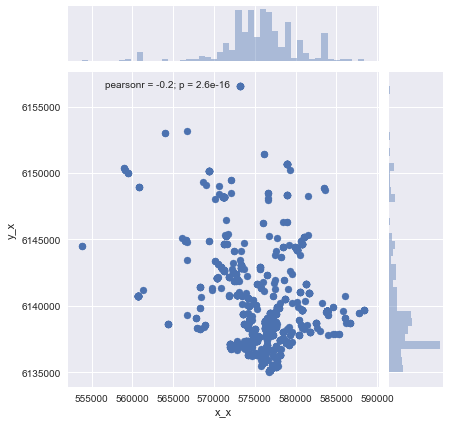

In [33]:
sns.jointplot(x="x_x", y="y_x", data=rmerge);

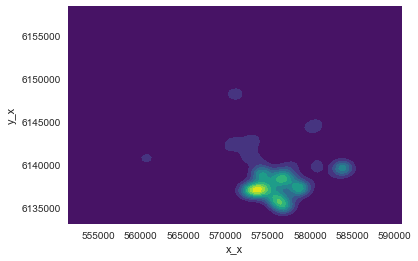

In [39]:
sns.kdeplot(rmerge['x_x'], rmerge['y_x'], shade=True, cmap='viridis');

In [36]:
type(rmerge)

pandas.core.frame.DataFrame

In [38]:
gpd.GeoDataFrame?

In [40]:
barrios = gpd.read_file(barrios_shp_path)

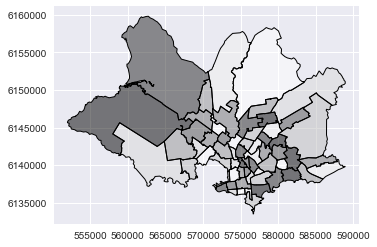

In [41]:
barrios.plot()

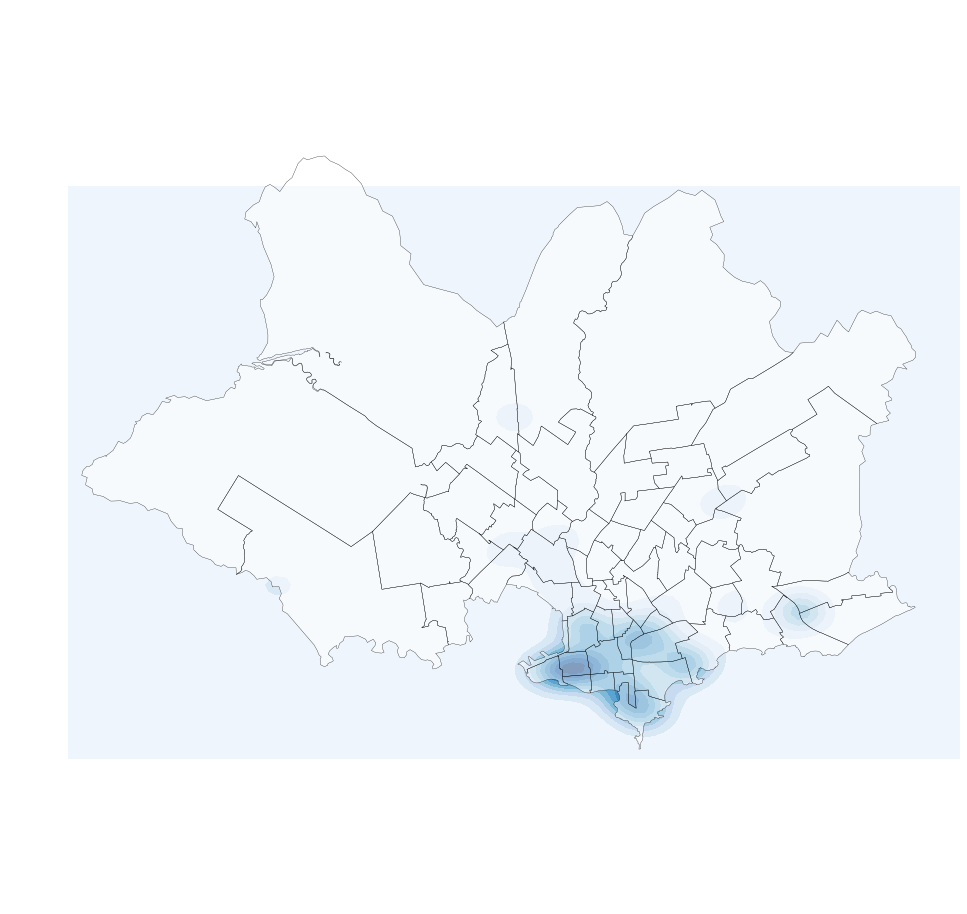

In [52]:
f, ax = plt.subplots(1, figsize=(16, 16))

barrios.plot(color='white', linewidth=0.3, ax=ax)

sns.kdeplot(rmerge['x_x'], rmerge['y_x'], \
            shade=True, cmap='Blues', \
            ax=ax);

#sns.kdeplot(rmerge['x_y'], rmerge['y_y'], \
#            shade=True, cmap='Reds', \
#            ax=ax);

ax.set_axis_off()
plt.axis('equal')
plt.show()

In [8]:
file = 

FileNotFoundError: [Errno 2] No such file or directory: 'comoir/comoir_2010_1.csv.dbf'

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x8b in position 1: invalid start byte

In [5]:
d = pd.DataFrame(columns=['codigo1', 'codigo2', 'tipo'],data=np.array([100;200;1]))

SyntaxError: invalid syntax (<ipython-input-5-8a063fe761f2>, line 1)

In [11]:
data = pd.read_csv('v_uptu_lugares/uptu_patrimonio.csv', delimiter=separador)

In [14]:
data

,codigo,nombre,direccion,x,y
0,654,CASA DE ANTONIO PEREZ,Av.Agraciada 2760.,573583.593476,6.139931e+06
1,719,PALACIO LEGISLATIVO,NaN,574275.529731,6.138716e+06
2,387,INSTITUTO DE HIGIENE,Alfredo Navarro 3051.,577630.070886,6.138497e+06
3,386,COMEDOR UNIVERSITARIO N°2,Alfredo Navarro 3087,577669.893178,6.138415e+06
4,23,MERCADO DEL PUERTO,Piedras 227.,572015.001483,6.137130e+06
5,633,SALADERO SECO Y ADUANA DE ORIBE,Rambla Rca. de Chile 3975,579669.838269,6.137174e+06
6,711,CEMENTERIO DEL PASO MOLINO,AV CARLOS MARIA RAMIREZ 322,570430.701732,6.142424e+06
7,50,ALMACEN DE TARANCO,Cerrito 470.,572490.138756,6.137153e+06
8,532,"CHALET ""LE GRIFFON""",Costa Rica 1561,586316.552948,6.138808e+06
9,558,CONJUNTO DE VIVIENDAS ALEJO ROSSELL Y RIUS,"Av. Gral. José Garibaldi, calle Marsella",574645.437864,6.140586e+06
